<a href="https://colab.research.google.com/github/jhChoi1997/KSNVE-AI-2022-summer/blob/main/code/2_Anomaly_Detection_using_Reconstruction_(ConvAutoEncoder).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2022년 인공지능 강습회 2일차 실습 코드**
## **Practice 2 : Anomaly Detection using Reconstruction (ConvolutionalAutoEncoder)**

In this project, you will implement Convolutional AutoEncoder for anomaly detection. For here, 0 to 6 numbers are used as normal data and 7 to 9 are used as anomaly data. 💻

## 1. Import packages
New library imported for this project: 
- `Scikit-learn` package: includes useful tools for data analysis & preprocessing (https://scikit-learn.org/stable/)
  - We use this package for `anomaly score` metrics
- `Matplot` library: for plotting graphs
- `Torchinfo`: summarizes and print formatted `model information` 

In [ ]:
!pip install torchinfo                                                          # install torchinfo module 
import torch
from torch import nn
from torchvision import datasets                                                # https://pytorch.org/vision/stable/datasets.html
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn import metrics                                                     # for Anomaly scores (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
import matplotlib.pyplot as plt                                                 # for plotting (https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html)
from torchinfo import summary                                                   # for model summary (https://github.com/TylerYep/torchinfo)
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  ## use gpu if available
print(f'Using {device} device')

Using cuda device


In [ ]:
plt.rc('font', size=20)                                                         # set the pyplot object with given property (https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.rc.html)

## 2. Hyperparameters
You can change the hyperparameter below.
Parameter `ANOMALY_NUM` means which number to set as an anomaly.

In [ ]:
EPOCHS = 10                                                                     # Number of epoches to train
BATCH = 32                                                                      # Minibatch size
ANOMALY_NUM = [7,8,9]                                                           # (list) anomalous data
NORMAL_NUM =  [0,1,2,3,4,5,6]                                                   # (list) normal data  

## 3. Dataset and Dataloader

Here we use MNIST dataset. 
The datatype of the dataset is a TorchTensor of tuples: (`image tensor`, `target label`)

The dimensions of an image tensor is (`channel`=1, `width`=28, `height` =28)

Here, we use `Subset` package in `torch.utils.data` to build two sub-datasets (validation, test).

MNIST dataset: https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

In [ ]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test  = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)

### 3-1. Define training & test dataset 

In [ ]:
train_idx = [i for i,v in enumerate(mnist_train) if v[1] in NORMAL_NUM]         # get a list of indices with NORMAL_NUM, v is the tuple of (image tensor, label)
train_dataset = Subset(mnist_train,train_idx)                                   # get a subset of dataset using train_idx
                                     
testdigit = ANOMALY_NUM + NORMAL_NUM                                            # join two list
test_idx =[i for i,v in enumerate(mnist_test) if v[1] in testdigit]
Num_test = int(len(test_idx)/2);

test_dataset = Subset(mnist_test,test_idx[:Num_test])
val_dataset = Subset(mnist_test,test_idx[Num_test:])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

Dataset length is like below.

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

41935
5000
5000


## 4. Define a DNN model 

We will use both simple AutoEncoder and Convolutional AutoEncoder. 

### 4-1. Simple AutoEncoder

The same model with practice 1-1.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoding_dim = encoding_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28, self.encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dim, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = x.reshape(x.size(0), -1)
        out = self.encoder(out)
        out = self.decoder(out)
        out = out.view(x.size())
        return out

In [ ]:
model = AutoEncoder(64).to(device)
summary(model,input_size=(BATCH,1,28,28))                                       # summary(model, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [32, 1, 28, 28]           --
├─Sequential: 1-1                        [32, 64]                  --
│    └─Linear: 2-1                       [32, 64]                  50,240
│    └─ReLU: 2-2                         [32, 64]                  --
├─Sequential: 1-2                        [32, 784]                 --
│    └─Linear: 2-3                       [32, 784]                 50,960
│    └─Sigmoid: 2-4                      [32, 784]                 --
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
Total mult-adds (M): 3.24
Input size (MB): 0.10
Forward/backward pass size (MB): 0.22
Params size (MB): 0.40
Estimated Total Size (MB): 0.72

#### 4-1-1. Define loss function

In [ ]:
loss_fn = nn.MSELoss()                                                          # create MSE loss object (default reduction: 'mean')
anomaly_score = nn.MSELoss(reduction='none')                                    # https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#### 4-1-2. Define trainer object

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        X = X[0].to(device)                                                     # change to tensor data type adequate for the current device
        pred = model(X)
        loss = loss_fn(pred, X)
        for idata in range(pred.shape[0]):
            iloss = loss_fn(pred[idata,:,:], X[idata,:,:])
            losses.append(iloss)                                                # build losses matrix for individual samples   (BATCH)

        optimizer.zero_grad()                                                   # init gradient in optimizer
        loss.backward()                                                         # calculate gradient
        optimizer.step()                                                        # gradient descent
        if batch % 300 == 0:                                                    # for every 300 minibatches              
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    losses = [i.item() for i in losses]
    return np.mean(losses)

#### 4-1-3. Define test object
Evaluate the model and plot results

In [ ]:
def test(dataloader, model, loss_fn, anomaly_score, draw_mode = False):
    model.eval()                                                                # turn on the evaluation mode

    y_true, y_pred = [], []
    normal_loss = []                                                            # separately calculate losses for normal and abnormal data
    anomaly_loss = []

    with torch.no_grad():                                                       # turn-off the gradient tracker   
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)                                   # send to GPU or CPU
            output = model(X)                                                   # (BATCH,CH,H,W)

            for idata in range(output.shape[0]):                                # output from the model is a tensor of information
                loss = loss_fn(output[idata,:,:], X[idata,:,:])
                if y[idata] in NORMAL_NUM:
                    y[idata] = 0                                                # replace original digit label (number) to 0 and 1 (anomality)
                    normal_loss.append(loss)
                elif y[idata] in ANOMALY_NUM:
                    y[idata] = 1
                    anomaly_loss.append(loss)
            
            score = torch.mean(anomaly_score(X, output), (1, 2, 3))             # average in (CH,H,W) dims

            y_true.extend(y.tolist())                                           # torchtensor -> list and extend to list y_true
            y_pred.extend(score.tolist())

    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(5,5))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')

    print(f'ROC AUC: {roc_auc:>0.3f}')
    normal_loss = [i.item() for i in normal_loss]
    anomaly_loss = [i.item() for i in anomaly_loss]
    normal_loss_mean = np.mean(normal_loss)
    anomaly_loss_mean = np.mean(anomaly_loss)
    print(f'normal loss : {normal_loss_mean}')
    print(f'anomaly loss : {anomaly_loss_mean}')
    return roc_auc.item(), normal_loss_mean, anomaly_loss_mean, normal_loss, anomaly_loss

In [ ]:
aucs = []
train_normal_losses = []
val_normal_losses = []
val_anomaly_losses = []
best_auc = 0
best_model = model.to(device)                                                   # allocate model to GPU or CPU

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_normal_loss = train(train_dataloader, model, loss_fn, optimizer)      # train for single epoch
    auc, val_normal_loss, val_anomaly_loss, _, _ = test(val_dataloader, model, loss_fn, anomaly_score)    # validation for single epoch

    train_normal_losses.append(train_normal_loss)
    aucs.append(auc)
    val_normal_losses.append(val_normal_loss)
    val_anomaly_losses.append(val_anomaly_loss)
    if best_auc < auc:                                                          # as num of epoch increases, store the best model (based on AUC)
      best_model = model
      best_auc = auc

Epoch 1
-------------------------------
loss: 0.232632  [    0/41935]
loss: 0.038701  [ 9600/41935]
loss: 0.025752  [19200/41935]
loss: 0.017195  [28800/41935]
loss: 0.016075  [38400/41935]
ROC AUC: 0.765
normal loss : 0.012983449783369877
anomaly loss : 0.0200868413117933
Epoch 2
-------------------------------
loss: 0.014400  [    0/41935]
loss: 0.010636  [ 9600/41935]
loss: 0.011121  [19200/41935]
loss: 0.009524  [28800/41935]
loss: 0.008098  [38400/41935]
ROC AUC: 0.752
normal loss : 0.007302081709272597
anomaly loss : 0.011032304303851853
Epoch 3
-------------------------------
loss: 0.007846  [    0/41935]
loss: 0.007570  [ 9600/41935]
loss: 0.006382  [19200/41935]
loss: 0.005548  [28800/41935]
loss: 0.006255  [38400/41935]
ROC AUC: 0.752
normal loss : 0.005687032933191043
anomaly loss : 0.008683452676456647
Epoch 4
-------------------------------
loss: 0.006461  [    0/41935]
loss: 0.005840  [ 9600/41935]
loss: 0.005948  [19200/41935]
loss: 0.006016  [28800/41935]
loss: 0.004949

<Figure size 432x288 with 0 Axes>

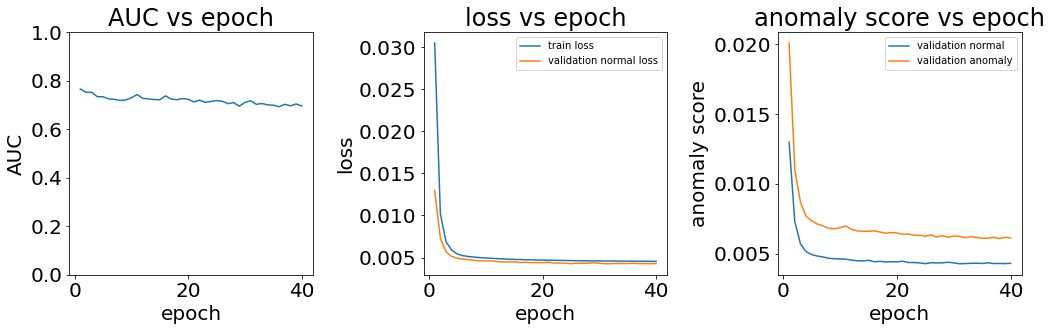

In [ ]:
plt.clf()
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(list(range(1,len(aucs)+1)),aucs)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(1,3,2)
plt.plot(list(range(1,len(train_normal_losses)+1)),train_normal_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend(['train loss', 'validation normal loss'], fontsize=10)

plt.subplot(1,3,3)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.plot(list(range(1,len(val_anomaly_losses)+1)),val_anomaly_losses)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal','validation anomaly'], fontsize=10)

plt.tight_layout()

ROC AUC: 0.697
normal loss : 0.004822943700083898
anomaly loss : 0.007004297407999767


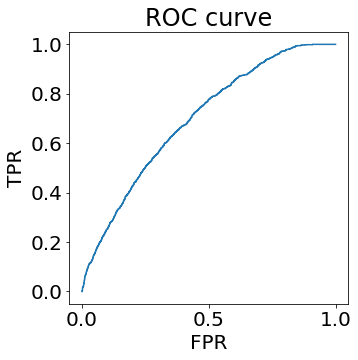

In [ ]:
auc, _, _, test_normal_score, test_anomaly_score = test(test_dataloader, best_model, loss_fn, anomaly_score, True)

<Figure size 720x720 with 0 Axes>

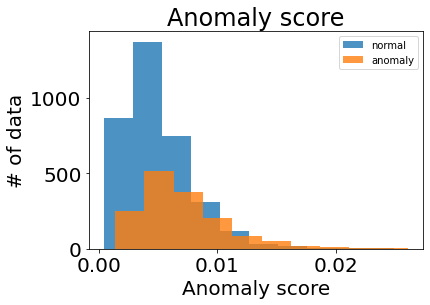

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.hist(test_normal_score, alpha = 0.8)
plt.hist(test_anomaly_score, alpha = 0.8)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('# of data')
plt.legend(['normal','anomaly'], fontsize=10)
plt.figure(figsize=(10,10))

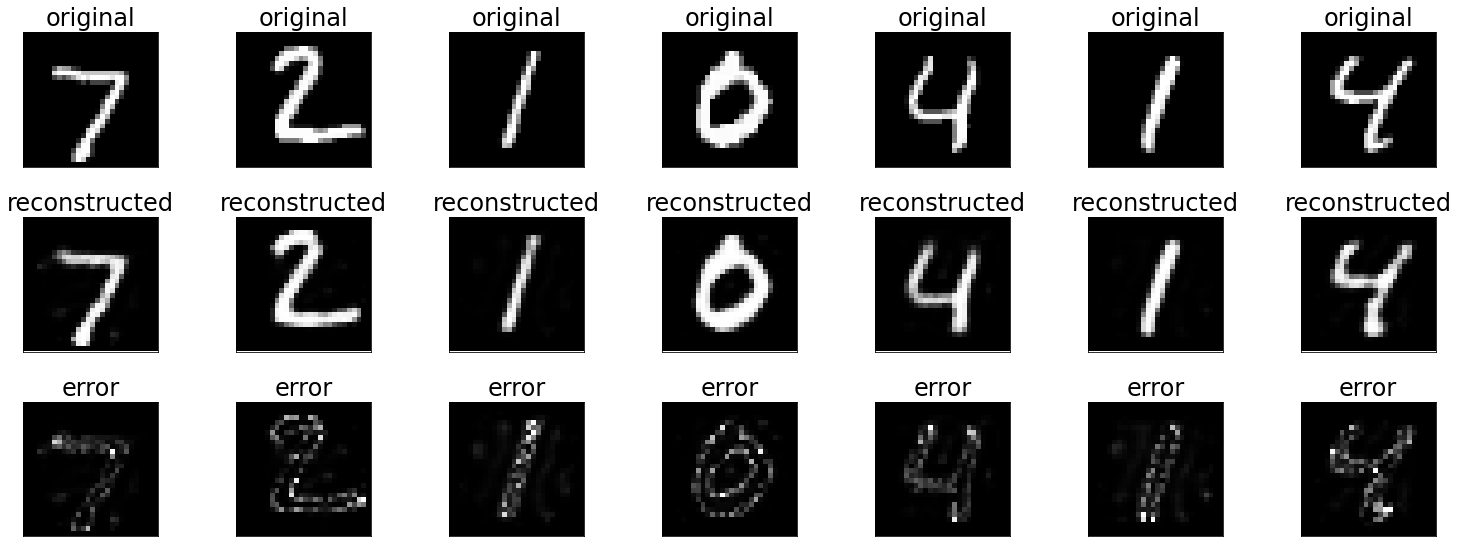

In [ ]:
plt.rc('font', size=20)
n = 7
plt.figure(figsize=(3*n, 8))

for i in range(n):
  input_image = test_dataset[i][0].to(device)
  output_image = best_model(input_image.unsqueeze(0))
  error_image = torch.abs(input_image[0]-output_image[0])
  
  ax = plt.subplot(3, n, i+1 )
  plt.imshow(input_image[0].cpu())
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, n + i + 1)
  plt.imshow(output_image[0].squeeze().detach().cpu())
  plt.title('reconstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, 2*n + i + 1)
  plt.imshow(error_image.squeeze().detach().cpu())
  plt.title('error')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

### 4-2. Convolutional AutoEncoder

We will build a new Convolutional Autoencoder. The figure below shows the structures of the model.

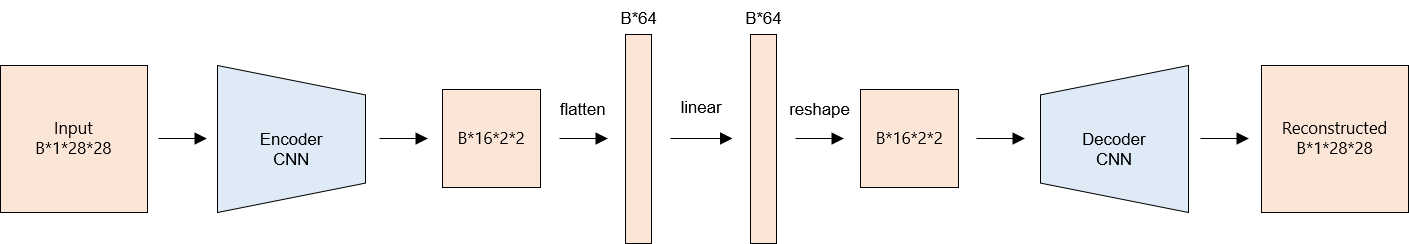

### CNN Encoder

Encoder consists of four 2D convolution layers with `kernel_size`=3 and `stride`=2. Each convolution layer has different `in_channels` and `out_channels`.

More details for `nn.Conv2d` layer: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

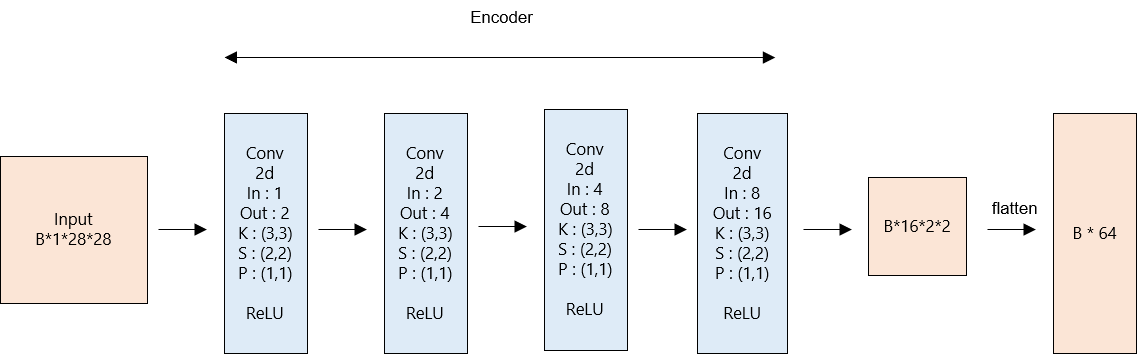

### Linear layer (Between Encoder and Decoder)

Linear layer consists of four linear layers with `nn.ReLU` activation layers.

More details for 

`nn.Linear` layer: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

`nn.ReLU` layer: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

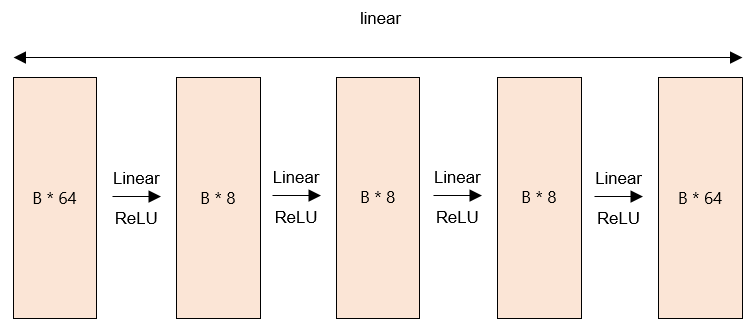

### CNN Decoder

Decoder consists of four 2D transposed convolution layers, which is different from Encoder.

More details for `nn.ConvTranspose2d` layer: https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

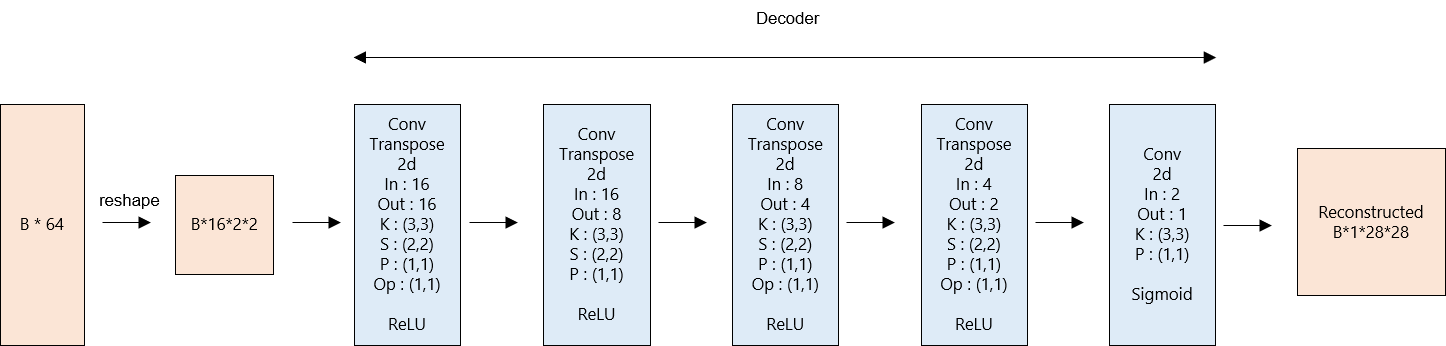

In [ ]:
del model

### 4-2-1. Define Convolutional AutoEncoder

In [ ]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(                                           # CNN Encoder
            nn.Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=1),      
            nn.ReLU(),
            nn.Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.ReLU())
        self.linear = nn.Sequential(                                            # Linear layer
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(                                           # CNN Decoder
            nn.ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(2, 1, kernel_size=(3, 3), padding=(1, 1)),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.encoder(x)
        output = output.view(-1,64)
        output = self.linear(output)
        output = output.view(-1, 16, 2, 2)
        output = self.decoder(output)
        return output

In [ ]:
model = ConvAutoEncoder().to(device)
summary(model,input_size=(BATCH,1,28,28))  # summary(model, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
ConvAutoEncoder                          [32, 1, 28, 28]           --
├─Sequential: 1-1                        [32, 16, 2, 2]            --
│    └─Conv2d: 2-1                       [32, 2, 14, 14]           20
│    └─ReLU: 2-2                         [32, 2, 14, 14]           --
│    └─Conv2d: 2-3                       [32, 4, 7, 7]             76
│    └─ReLU: 2-4                         [32, 4, 7, 7]             --
│    └─Conv2d: 2-5                       [32, 8, 4, 4]             296
│    └─ReLU: 2-6                         [32, 8, 4, 4]             --
│    └─Conv2d: 2-7                       [32, 16, 2, 2]            1,168
│    └─ReLU: 2-8                         [32, 16, 2, 2]            --
├─Sequential: 1-2                        [32, 64]                  --
│    └─Linear: 2-9                       [32, 8]                   520
│    └─ReLU: 2-10                        [32, 8]                   --
│    └─Lin

In [ ]:
loss_fn = nn.MSELoss()                                                          # create MSE loss object (default reduction: 'mean')
anomaly_score = nn.MSELoss(reduction='none')                                    # https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## 5. PR-AUC
measure PR-AUC.

You can use **average_precision_score**.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html


In [ ]:
## Define trainer object
def train(dataloader, model, loss_fn, optimizer):
    model.train()                                                               # turn on the train mode

    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        X = X[0].to(device)                                                     # change to tensor data type adequate for the current device 
        pred = model(X)                                                         # make prediction from a model
        loss = loss_fn(pred, X)                                                 # calc loss function

        for idata in range(pred.shape[0]):
            iloss = loss_fn(pred[idata,:,:], X[idata,:,:])
            losses.append(iloss)                                                # build losses matrix for individual samples   (BATCH)              

        optimizer.zero_grad()                                                   # init gradient in optimizer
        loss.backward()                                                         # calculate gradient
        optimizer.step()                                                        # gradient descent

        if batch % 300 == 0:                                                    # display progress for every 300 minibatches              
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    losses = [i.item() for i in losses]                                         # convert the tensor losses to a list
    return np.mean(losses)

In [ ]:
## Define test object: evaluate the model and plot results
def test(dataloader, model, loss_fn, anomaly_score, draw_mode = False):
    model.eval()                                                                # turn on the evaluation mode

    y_true, y_pred = [], []
    normal_loss = []                                                            # separately calculate losses for normal and abnormal data
    anomaly_loss = []

    with torch.no_grad():                                                       # turn-off the gradient tracker   
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)                                   # send to GPU or CPU
            output = model(X)                                                   # (BATCH,CH,H,W)

            for idata in range(output.shape[0]):                                # output from the model is a tensor of information
                loss = loss_fn(output[idata,:,:], X[idata,:,:])
                if y[idata] in NORMAL_NUM:
                    y[idata] = 0                                                # replace original digit label (number) to 0 and 1 (anomality)
                    normal_loss.append(loss)
                elif y[idata] in ANOMALY_NUM:
                    y[idata] = 1
                    anomaly_loss.append(loss)
            
            score = torch.mean(anomaly_score(X, output), (1, 2, 3))             # average in (CH,H,W) dims

            y_true.extend(y.tolist())                                           # torchtensor -> list and extend to list y_true
            y_pred.extend(score.tolist())

    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    roc_prauc = metrics.average_precision_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')

        plt.subplot(1,2,2)
        pr, rc, _ = metrics.precision_recall_curve(y_true,y_pred)
        plt.plot(rc,pr)
        plt.title('precision-recall curve')
        plt.xlabel('recall')
        plt.ylabel('precision')


    print(f'ROC AUC: {roc_auc:>0.3f}')
    print(f'PR AUC: {roc_prauc:>0.3f}')
    normal_loss = [i.item() for i in normal_loss]
    anomaly_loss = [i.item() for i in anomaly_loss]
    normal_loss_mean = np.mean(normal_loss)
    anomaly_loss_mean = np.mean(anomaly_loss)
    print(f'normal loss : {normal_loss_mean}')
    print(f'anomaly loss : {anomaly_loss_mean}')
    return roc_auc.item(), normal_loss_mean, anomaly_loss_mean, normal_loss, anomaly_loss, roc_prauc.item()

In [ ]:
aucs = []
praucs = []
train_normal_losses = []
val_normal_losses = []
val_anomaly_losses = []
best_auc = 0
best_model = model.to(device)  ## allocate model to GPU or CPU

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")

    # train for single epoch
    train_normal_loss = train(train_dataloader, model, loss_fn, optimizer)
    # validation for single epoch
    auc, val_normal_loss, val_anomaly_loss, _, _, pr_auc = test(val_dataloader, model, loss_fn, anomaly_score)

    train_normal_losses.append(train_normal_loss)
    aucs.append(auc)
    praucs.append(pr_auc)
    val_normal_losses.append(val_normal_loss)
    val_anomaly_losses.append(val_anomaly_loss)
    if best_auc < auc:                                                          # as num of epoch increases, store the best model (based on AUC)
      best_model = model
      best_auc = auc

Epoch 1
-------------------------------
loss: 0.208708  [    0/41935]
loss: 0.067355  [ 9600/41935]
loss: 0.062251  [19200/41935]
loss: 0.060665  [28800/41935]
loss: 0.056800  [38400/41935]
ROC AUC: 0.475
PR AUC: 0.263
normal loss : 0.05653681190222756
anomaly loss : 0.056522049558592725
Epoch 2
-------------------------------
loss: 0.055133  [    0/41935]
loss: 0.051374  [ 9600/41935]
loss: 0.048743  [19200/41935]
loss: 0.045472  [28800/41935]
loss: 0.053792  [38400/41935]
ROC AUC: 0.545
PR AUC: 0.300
normal loss : 0.04795339807517763
anomaly loss : 0.05144168455528733
Epoch 3
-------------------------------
loss: 0.042596  [    0/41935]
loss: 0.039603  [ 9600/41935]
loss: 0.047200  [19200/41935]
loss: 0.045396  [28800/41935]
loss: 0.040941  [38400/41935]
ROC AUC: 0.721
PR AUC: 0.504
normal loss : 0.04017891050555194
anomaly loss : 0.05407286857148545
Epoch 4
-------------------------------
loss: 0.044681  [    0/41935]
loss: 0.040842  [ 9600/41935]
loss: 0.035568  [19200/41935]
loss:

<Figure size 432x288 with 0 Axes>

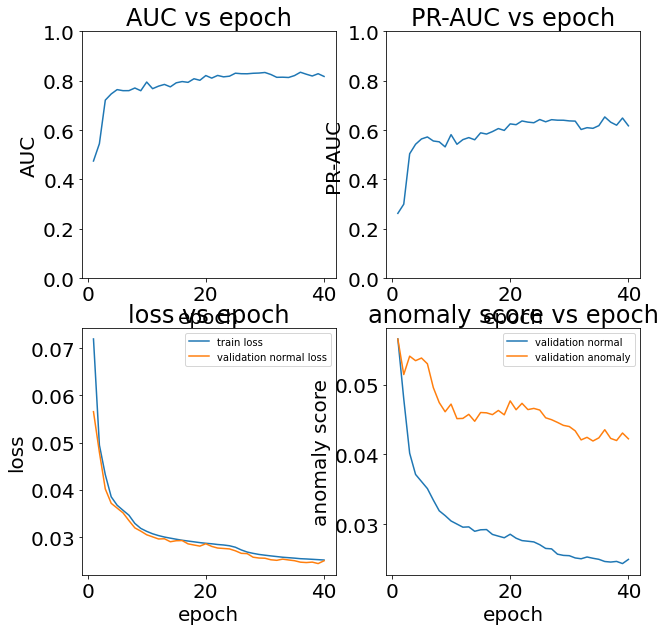

In [ ]:
plt.clf()
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(list(range(1,len(aucs)+1)),aucs)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(2,2,2)
plt.plot(list(range(1,len(praucs)+1)),praucs)
plt.xlabel('epoch')
plt.ylabel('PR-AUC')
plt.title('PR-AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(2,2,3)
plt.plot(list(range(1,len(train_normal_losses)+1)),train_normal_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend(['train loss', 'validation normal loss'], fontsize=10)

plt.subplot(2,2,4)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.plot(list(range(1,len(val_anomaly_losses)+1)),val_anomaly_losses)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal','validation anomaly'], fontsize=10)
plt.tight_layout()

ROC AUC: 0.789
PR AUC: 0.587
normal loss : 0.02540786571216591
anomaly loss : 0.041441224517887315


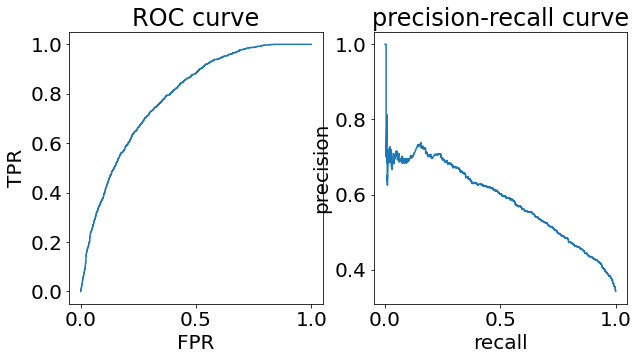

In [ ]:
auc, _, _, test_normal_score, test_anomaly_score, prauc = test(test_dataloader, best_model, loss_fn, anomaly_score, True)

<Figure size 720x720 with 0 Axes>

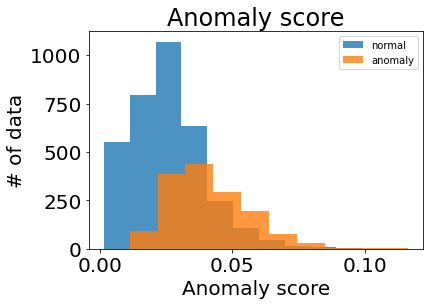

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.hist(test_normal_score, alpha = 0.8)
plt.hist(test_anomaly_score, alpha = 0.8)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('# of data')
plt.legend(['normal','anomaly'], fontsize=10)
plt.figure(figsize=(10,10))

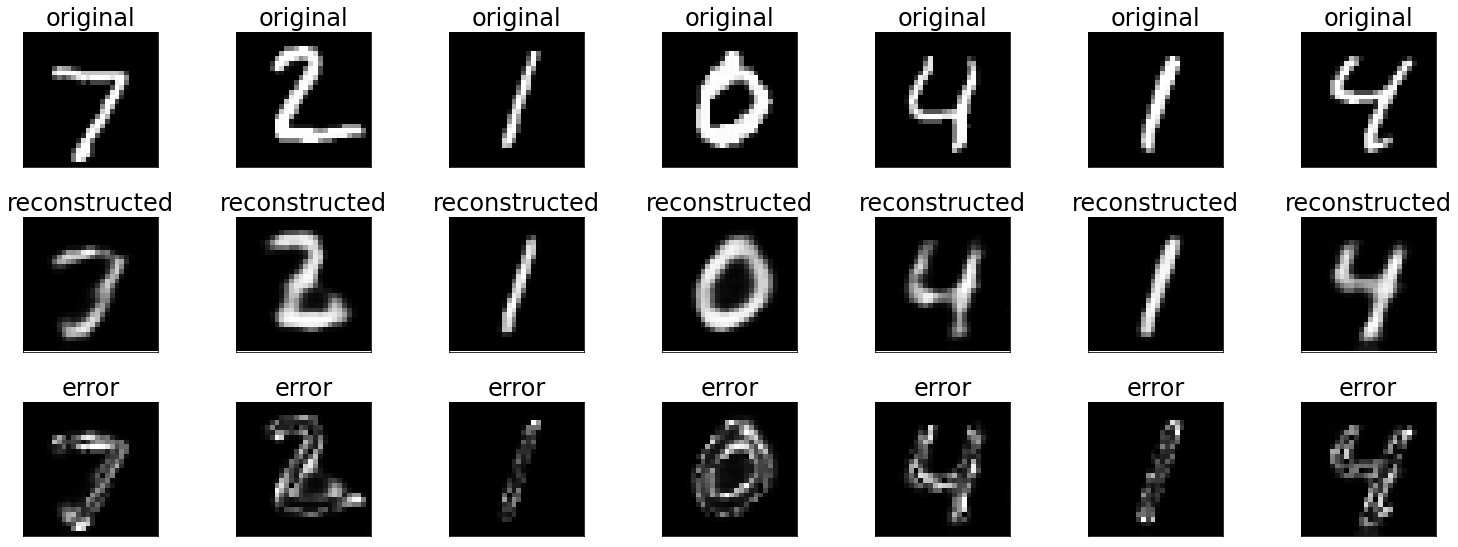

In [ ]:
plt.rc('font', size=20)
n = 7                                                                           # num of data to plot
plt.figure(figsize=(3*n, 8))


for i in range(n):
  input_image = test_dataset[i][0].to(device)
  output_image = best_model(input_image.unsqueeze(0))
  error_image = torch.abs(input_image[0]-output_image[0])
  
  ax = plt.subplot(3, n, i+1 )
  plt.imshow(input_image[0].cpu())
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, n + i + 1)
  plt.imshow(output_image[0].squeeze().detach().cpu())
  plt.title('reconstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, 2*n + i + 1)
  plt.imshow(error_image.squeeze().detach().cpu())
  plt.title('error')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()